# Deforestation monitoring using NDVI value comparison

This notebook contains the script to download the data, slice the image into 100 patches, stack up the bands to form true and ndvi patches, compare 2 batches (diff. time periods), calculate the total area deforestated and finally visuzlize the ndvi mask.

Note: 
1. Healthy vegetation like forest reflects near infrared really well and absorbs red light for use in phtosynthesis
2. Dying vegeation absorbs NIR and reflects red light

In [ ]:
# install necessary libraries

!pip install rasterio

In [2]:
#import required libraries

import numpy as np
import os
import rasterio
from PIL import Image
from rasterio import plot
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# download the data using url from copernicus open hub

# Note: Change the url path acordingly

'''
!wget --content-disposition --continue --user='...' --password='...' "https://scihub.copernicus.eu/dhus/odata/v1/Products('dbef22c0-2ac7-4555-8a99-6dc5d19724cb')/\$value" 
!wget --content-disposition --continue --user='...' --password='...' "https://scihub.copernicus.eu/dhus/odata/v1/Products('35ab318a-03bd-4ca7-bb15-d869bf494c95')/\$value"
'''

In [ ]:
# unzip the downloaded data

# Note: Change the zip file name acordingly

'''
!unzip S2B_MSIL2A_20210901T141049_N0301_R110_T20KPA_20210901T165603.zip
!unzip S2B_MSIL2A_20190902T141049_N0213_R110_T20KPA_20190902T194937.zip
'''

In [3]:
# mont drive to load the data

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# import bands from first batch

# Note 1: This data was manually downloaded from Sentinel hub and stored on my drive.
# Data link: https://drive.google.com/drive/folders/1u2-c3O2lZn0_zImOH0A-z_dxc5M8rHcY?usp=sharing

# Note 2: If you are downloading the data using the previous cell commands, make sure to change the path and image name accordingly.

imagePath = '/content/drive/MyDrive/Colab Notebooks/Data/Sentinel_2/Batch-1/'  
b1_band2 = rasterio.open(imagePath+'T20KPA_20190902T141049_B02_10m.jp2', driver='JP2OpenJPEG') #blue
b1_band3 = rasterio.open(imagePath+'T20KPA_20190902T141049_B03_10m.jp2', driver='JP2OpenJPEG') #green
b1_band4 = rasterio.open(imagePath+'T20KPA_20190902T141049_B04_10m.jp2', driver='JP2OpenJPEG') #red
b1_band8 = rasterio.open(imagePath+'T20KPA_20190902T141049_B08_10m.jp2', driver='JP2OpenJPEG') #nir

In [5]:
# import bands from second batch

# Note 1: This data was manually downloaded from Sentinel hub and stored on my drive.
# Data link: https://drive.google.com/drive/folders/1u2-c3O2lZn0_zImOH0A-z_dxc5M8rHcY?usp=sharing

# Note 2: If you are downloading the data using the previous cell commands, make sure to change the path and image name accordingly.

imagePath = '/content/drive/MyDrive/Colab Notebooks/Data/Sentinel_2/Batch-2/'
b2_band2 = rasterio.open(imagePath+'T20KPA_20210901T141049_B02_10m.jp2', driver='JP2OpenJPEG') #blue
b2_band3 = rasterio.open(imagePath+'T20KPA_20210901T141049_B03_10m.jp2', driver='JP2OpenJPEG') #green
b2_band4 = rasterio.open(imagePath+'T20KPA_20210901T141049_B04_10m.jp2', driver='JP2OpenJPEG') #red
b2_band8 = rasterio.open(imagePath+'T20KPA_20210901T141049_B08_10m.jp2', driver='JP2OpenJPEG') #nir


In [6]:
# image shape

np.seterr(divide='ignore', invalid='ignore')
img_width,img_height = b1_band2.width,b1_band2.height
print('Image Width:', img_width)
print('Image Height:',img_height)

Image Width: 10980
Image Height: 10980


In [7]:
# raster values as matrix array batch 1

b1_red_array = b1_band4.read(1)
b1_green_array = b1_band3.read(1)
b1_blue_array = b1_band2.read(1)
b1_nir_array = b1_band8.read(1)

In [8]:
# raster values as matrix array batch 2

b2_red_array = b2_band4.read(1)
b2_green_array = b2_band3.read(1)
b2_blue_array = b2_band2.read(1)
b2_nir_array = b2_band8.read(1)

In [9]:
# helper functions

def normalize(array):
    array_min, array_max = 0, 2500
    return (array - array_min) / (array_max - array_min)


def slice_image(channel1,channel2,channel3,windowsize,batch,img_type):
  directory = 'img_patches/batch_' + str(batch) + '/' + img_type + '/'
  if not os.path.exists(directory):
    os.makedirs(directory)
  # Crop out the window, stack and normalise
  img_num = 0
  for r in range(0, channel1.shape[0], windowsize):
    for c in range(0, channel1.shape[1], windowsize):
      first_channel = normalize(channel1[r:r+windowsize,c:c+windowsize])
      second_channel = normalize(channel2[r:r+windowsize,c:c+windowsize])
      third_channel = normalize(channel3[r:r+windowsize,c:c+windowsize])
      stacked_img = np.dstack((first_channel,second_channel,third_channel))
      save_img = Image.fromarray((stacked_img * 255).astype(np.uint8))
      save_img.save(directory+'img'+str(img_num)+'.jpg')
      img_num+=1
  print('Image sliced into',img_num,'patches and saved.')


def create_ndvi_mask(full_nir_channel,full_red_channel,batch):
  directory = 'img_patches/batch_' + str(batch) + '/ndvi_mask/'
  if not os.path.exists(directory):
    os.makedirs(directory)
  # Crop out the window, stack and normalise
  img_num = 0
  for r in range(0, full_nir_channel.shape[0], windowsize):
    for c in range(0, full_nir_channel.shape[1], windowsize):
      nir_channel = full_nir_channel[r:r+windowsize,c:c+windowsize]
      red_channel = full_red_channel[r:r+windowsize,c:c+windowsize]
      ndvi_img = (nir_channel.astype(float) - red_channel.astype(float)) / (nir_channel  + red_channel)
      ndvi_img_array = (((ndvi_img - ndvi_img.min()) / (ndvi_img.max() - ndvi_img.min())) * 255).astype(np.uint8)
      ndvi_mask_img = np.copy(ndvi_img_array)
      ndvi_mask_img[np.where(ndvi_img_array<150)] = 0       # Non-Forest 
      ndvi_mask_img[np.where(ndvi_img_array>150)] = 255     # Forest
      ndvi_img_save = Image.fromarray(ndvi_mask_img)
      ndvi_img_save.save(directory+'img'+str(img_num)+'.jpg')
      #plt.imsave(directory+'img'+str(img_num)+'.jpg', ndvi_img) 
      img_num+=1
  print('NDVI patches saved')

In [10]:
# slicing the image into smaller patches, forming true color composite and creating NDVI mask image

windowsize = 1098
slice_image(b1_red_array,b1_green_array,b1_blue_array,windowsize,1,'true_color')
create_ndvi_mask(b1_nir_array,b1_red_array,1)
slice_image(b2_red_array,b2_green_array,b2_blue_array,windowsize,2,'true_color')
create_ndvi_mask(b2_nir_array,b2_red_array,2)

Image sliced into 100 patches and saved.
NDVI patches saved
Image sliced into 100 patches and saved.
NDVI patches saved


In [23]:
# load the patch

patch_num = 10  #select any patch number from 0 to 99

true_color_batch1 = '/content/img_patches/batch_1/true_color'+'/img' + str(patch_num) + '.jpg'
ndvi_batch1 = '/content/img_patches/batch_1/ndvi_mask/img' + str(patch_num) + '.jpg'
true_color_batch2 = '/content/img_patches/batch_2/true_color'+'/img' + str(patch_num) + '.jpg'
ndvi_batch2 = '/content/img_patches/batch_2/ndvi_mask/img' + str(patch_num) + '.jpg'

true_color_batch1_img = Image.open(true_color_batch1)
ndvi_batch1_img = Image.open(ndvi_batch1)
true_color_batch2_img = Image.open(true_color_batch2)
ndvi_batch2_img = Image.open(ndvi_batch2)

ndvi_batch1_array = np.array(ndvi_batch1_img)
ndvi_batch2_array = np.array(ndvi_batch2_img)

In [27]:
# amount of deforestation

total_patch_area = 1098*1098*0.1
batch1_forest_area = (np.count_nonzero(ndvi_batch1_array == 255)) * 0.1
batch2_forest_area = (np.count_nonzero(ndvi_batch2_array == 255)) * 0.1
deforest_area = (abs(batch1_forest_area-batch2_forest_area))

print('Total area of the patch:', total_patch_area, 'km^2')
print('Total forest area in first batch:', batch1_forest_area, 'km^2')
print('Total forest area in second batch:', batch2_forest_area, 'km^2')
print('Total area doferested in the patch:', deforest_area, 'km^2')

Total area of the patch: 120560.40000000001 km^2
Total forest area in first batch: 83502.0 km^2
Total forest area in second batch: 52403.0 km^2
Total area doferested in the patch: 31099.0 km^2


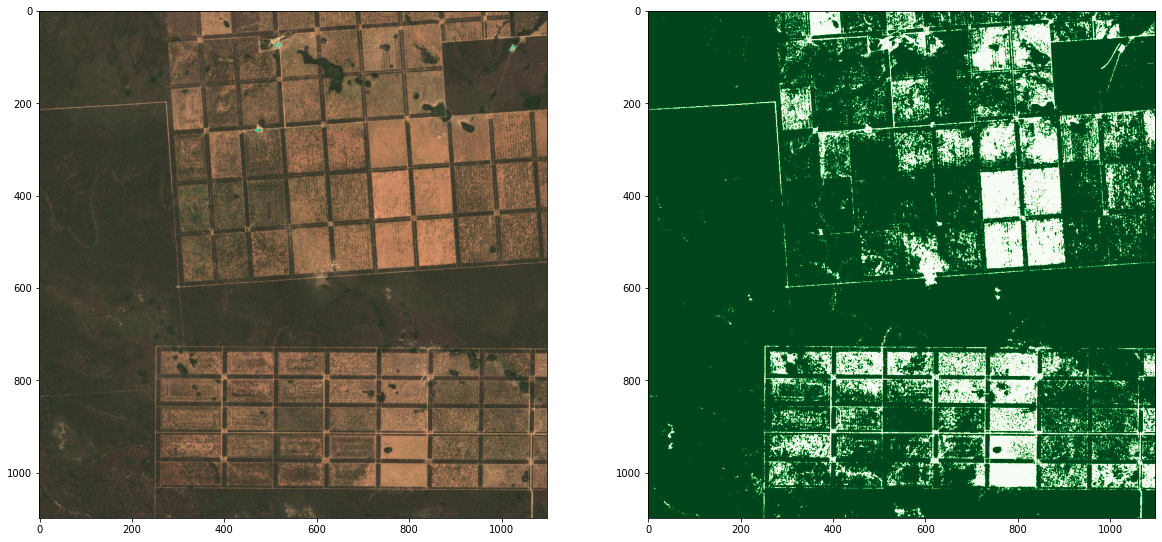

In [19]:
# visualize true color composite and NDVI mask of the patch in batch 1

f, axarr = plt.subplots(1,2,figsize=(20, 10))
axarr[0].imshow(true_color_batch1_img)
axarr[1].imshow(ndvi_batch1_img,cmap="Greens")
plt.show()

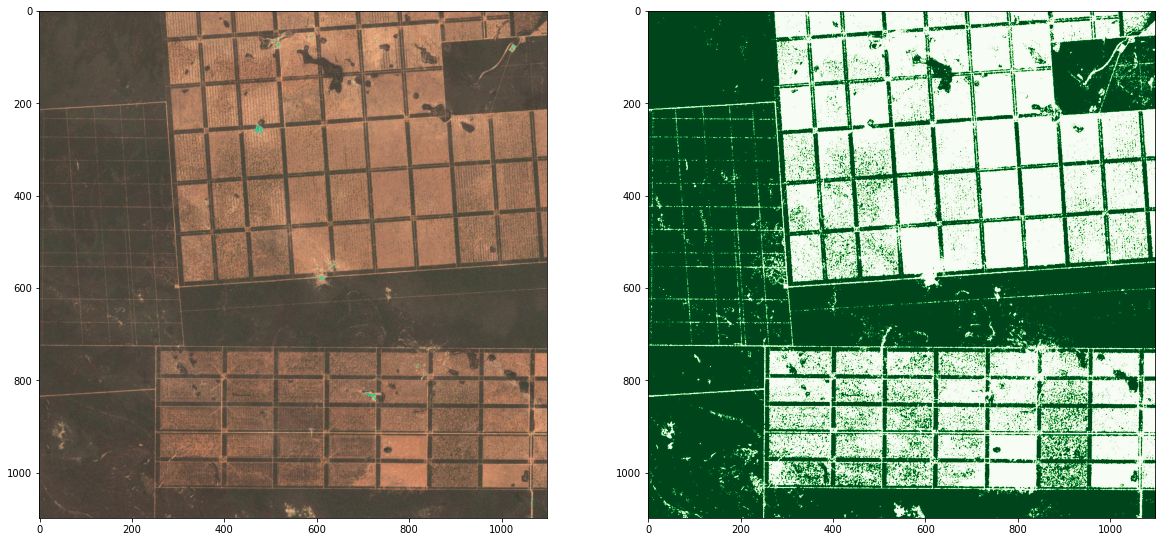

In [20]:
# visualize true color composite and NDVI mask of the same patch in batch 2

f, axarr = plt.subplots(1,2,figsize=(20, 10))
axarr[0].imshow(true_color_batch2_img)
axarr[1].imshow(ndvi_batch2_img,cmap="Greens")
plt.show()